# 2D Skull Stripping Segmentation NFBS Data

## Prepare NFBS Data

In [1]:
from nibabel.testing import data_path
import os
import cv2
import glob
from PIL import Image
import nibabel as nib
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from nipype.interfaces.slicer.filtering.n4itkbiasfieldcorrection import N4ITKBiasFieldCorrection
from nipype import Node, Workflow
from nilearn.image import resample_img
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import SimpleITK as sitk
from nilearn.image import math_img
from nilearn import image as nii
from nilearn import plotting
from nipype.interfaces.ants import N4BiasFieldCorrection
from tensorflow.keras.utils import plot_model, normalize

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
nfbs_path = "/media/james/ai_projects/NFBS_Dataset"
# voxel is a 3D MRI object can be split into MRI 2D slice images
voxel = nib.load("{}/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz".format(nfbs_path))

print("Shape of voxel=", voxel.shape)

Shape of voxel= (256, 256, 192)


### Create DataFrame with Image Locations - Masks - Skull Stripped Images

In [3]:
# store the address of 3 types of files
brain_mask = list()
brain = list()
raw = list()

for subdir, dirs, files in os.walk(nfbs_path):
    for file in files:
        # print(os.path.join(subdir, file))
        filepath = subdir + os.sep + file
        
        if filepath.endswith(".gz"):
            if "_brainmask." in filepath:
                brain_mask.append(filepath)
            elif "_brain." in filepath:
                brain.append(filepath)
            else:
                raw.append(filepath)

In [4]:
nfbs_df = pd.DataFrame(
    {"brain_mask": brain_mask,
     "brain": brain,
     "raw": raw
    }
)

In [5]:
nfbs_df.head()

,brain_mask,brain,raw
0,/media/james/ai_projects/NFBS_Dataset/A0004372...,/media/james/ai_projects/NFBS_Dataset/A0004372...,/media/james/ai_projects/NFBS_Dataset/A0004372...
1,/media/james/ai_projects/NFBS_Dataset/A0005609...,/media/james/ai_projects/NFBS_Dataset/A0005609...,/media/james/ai_projects/NFBS_Dataset/A0005609...
2,/media/james/ai_projects/NFBS_Dataset/A0006025...,/media/james/ai_projects/NFBS_Dataset/A0006025...,/media/james/ai_projects/NFBS_Dataset/A0006025...
3,/media/james/ai_projects/NFBS_Dataset/A0002818...,/media/james/ai_projects/NFBS_Dataset/A0002818...,/media/james/ai_projects/NFBS_Dataset/A0002818...
4,/media/james/ai_projects/NFBS_Dataset/A0002835...,/media/james/ai_projects/NFBS_Dataset/A0002835...,/media/james/ai_projects/NFBS_Dataset/A0002835...


/tmp/ipykernel_24028/715716633.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(nfbs_df.raw.iloc[i]).get_data()
/tmp/ipykernel_24028/715716633.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(nfbs_df.brain.iloc[i]).get_data()
/tmp/ipykernel_24028/715716633.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asa

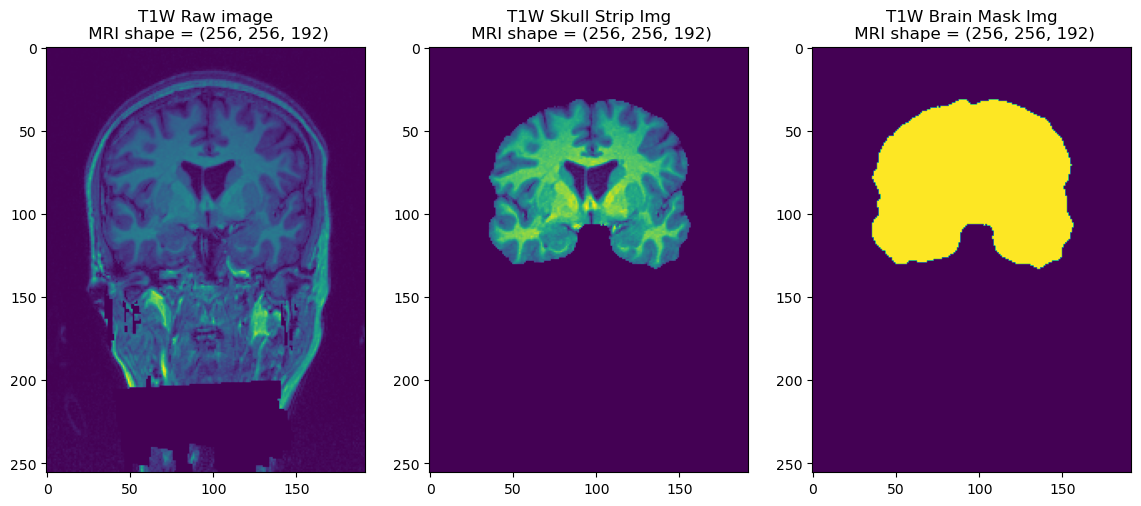

In [6]:
# visualize a couple of examples
for i in range(1):
    fig, ax = plt.subplots(1, 3, figsize=(14, 10))
    img = nib.load(nfbs_df.raw.iloc[i]).get_data()
    ax[0].set_title("T1W Raw image\n MRI shape = {}".format(img.shape))
    ax[0].imshow(img[img.shape[0]//2])

    img = nib.load(nfbs_df.brain.iloc[i]).get_data()
    ax[1].set_title("T1W Skull Strip Img\n MRI shape = {}".format(img.shape))
    ax[1].imshow(img[img.shape[0]//2])
    
    img = nib.load(nfbs_df.brain_mask.iloc[i]).get_data()
    ax[2].set_title("T1W Brain Mask Img\n MRI shape = {}".format(img.shape))
    ax[2].imshow(img[img.shape[0]//2])

### Perform Bias Field Correction, Cropping/Resizing, Intensity Normalization

- Bias field correction: bias field signal is a low-frequency and smooth signal that corrupts MRI images especially those produced by old MRI machines. Thus, bias field correction is done on MRIs prior to pushing them into image processing algorithms: segmentation, texture analysis, classification.
- Cropping and resizing: due to computational limits of fitting image to model, we reduce MRI image size from `(256*256*192) to (96*128*160)`. The target size is chosen in a way where most of the skull is captured after cropping and resizing it has a centering effect on images.
- Intensity normalization: shifts and scales an image so the pixels have a zero mean and unit variance. This helps the model converge faster by removing scale in-variance.

In [7]:
class preprocessing():
    def __init__(self, df):
        self.data = df
        self.raw_index = []
        self.mask_index = []
    def mkdir_prep_dir(self, name):
        """make preprocess directory if doesn't exist"""
        prep_dir = name
        if not os.path.exists(prep_dir):
            os.makedirs(prep_dir)
        return prep_dir
    def bias_correction(self):
        bias_dir = self.mkdir_prep_dir("bias_correction")
        n4 = N4BiasFieldCorrection()
        n4.inputs.dimension = 3
        n4.inputs.shrink_factor = 3
        n4.inputs.n_iterations = [20, 10, 10, 5]
        index_corr = []
        for i in tqdm(range(len(self.data))):
            n4.inputs.input_image = self.data.raw.iloc[i]
            n4.inputs.output_image = bias_dir + os.sep + str(i) + ".nii.gz"
            index_corr.append(bias_dir + os.sep + str(i) + ".nii.gz")
#             res = n4.run()
        index_corr = [bias_dir + os.sep + str(i) + ".nii.gz" for i in range(125)]
        self.data["bias_corr"] = index_corr
        print("bias corrected voxels stored at : {}/".format(bias_dir))
    def resize_crop(self):
        """ reducing the size of image due to memory constraints
                reducing size of image from 256*256*192 to 96*128*160 """
        self.rcrop_dir = self.mkdir_prep_dir("resized")
        target_shape = np.array((96,128,160))
        new_resolution = [2,]*3
        new_affine = np.zeros((4,4))
        new_affine[:3,:3] = np.diag(new_resolution)
        # putting point 0,0,0 in the middle of the new volume - this
        # could be refined in the future
        new_affine[:3,3] = target_shape*new_resolution/2.*-1
        new_affine[3,3] = 1.
        raw_index = []
        mask_index = []
        # resizing both image and mask and storing in folder
        for i in tqdm(range(len(self.data))):
            print("self.data.bias_corr.iloc[i] = {}".format(self.data.bias_corr.iloc[i]))
#             downsampled_and_cropped_nii = resample_img(
#                 self.data.bias_corr.iloc[i], target_affine=new_affine,
#                 target_shape=target_shape, interpolation="nearest")
#             downsampled_and_cropped_nii.to_filename(
#                 self.rcrop_dir + os.sep + "raw" + str(i) + ".nii.gz")
            self.raw_index.append(self.rcrop_dir + os.sep + "raw" + str(i) + ".nii.gz")
            
            print("self.data.brain_mask.iloc[i] = {}".format(self.data.brain_mask.iloc[i]))
#             downsampled_and_cropped_nii = resample_img(
#                 self.data.brain_mask.iloc[i], target_affine=new_affine,
#                 target_shape=target_shape, interpolation="nearest")
#             downsampled_and_cropped_nii.to_filename(
#                 self.rcrop_dir + os.sep + "mask" + str(i) + ".nii.gz")
            self.mask_index.append(self.rcrop_dir + os.sep + "mask" + str(i) + ".nii.gz")
        return self.raw_index, self.mask_index
    
    def intensity_normalization(self):
        for i in tqdm(self.raw_index):
            image = sitk.ReadImage(i)
            resacleFilter = sitk.RescaleIntensityImageFilter()
            resacleFilter.SetOutputMaximum(255)
            resacleFilter.SetOutputMinimum(0)
            image = resacleFilter.Execute(image)
            sitk.WriteImage(image, i)
        print("Normalization done. Voxels stored at: {}/".format(self.rcrop_dir))

In [8]:
pre = preprocessing(nfbs_df)
pre.bias_correction()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 22326.28it/s]

bias corrected voxels stored at : bias_correction/


In [9]:
r_ind, g_ind = pre.resize_crop()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 26214.40it/s]

self.data.bias_corr.iloc[i] = bias_correction/0.nii.gz
self.data.brain_mask.iloc[i] = /media/james/ai_projects/NFBS_Dataset/A00043721/sub-A00043721_ses-NFB3_T1w_brainmask.nii.gz
self.data.bias_corr.iloc[i] = bias_correction/1.nii.gz
self.data.brain_mask.iloc[i] = /media/james/ai_projects/NFBS_Dataset/A00056097/sub-A00056097_ses-NFB3_T1w_brainmask.nii.gz
self.data.bias_corr.iloc[i] = bias_correction/2.nii.gz
self.data.brain_mask.iloc[i] = /media/james/ai_projects/NFBS_Dataset/A00060259/sub-A00060259_ses-NFB3_T1w_brainmask.nii.gz
self.data.bias_corr.iloc[i] = bias_correction/3.nii.gz
self.data.brain_mask.iloc[i] = /media/james/ai_projects/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz
self.data.bias_corr.iloc[i] = bias_correction/4.nii.gz
self.data.brain_mask.iloc[i] = /media/james/ai_projects/NFBS_Dataset/A00028352/sub-A00028352_ses-NFB3_T1w_brainmask.nii.gz
self.data.bias_corr.iloc[i] = bias_correction/5.nii.gz
self.data.brain_mask.iloc[i] = /media/james/ai_projects

In [ ]:
pre.intensity_normalization()

/tmp/ipykernel_24028/1051910615.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(r_ind[i]).get_data()
/tmp/ipykernel_24028/1051910615.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(g_ind[i]).get_data()


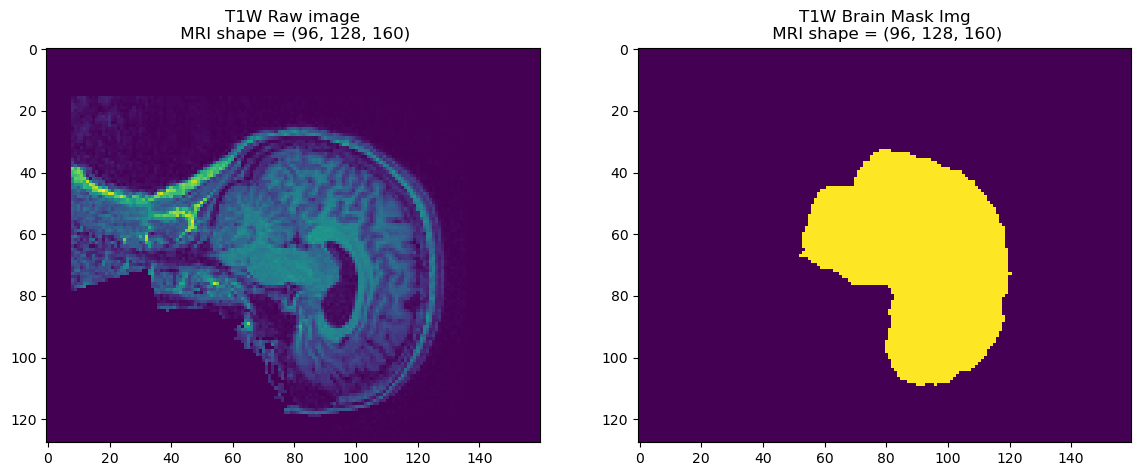

In [10]:
# visualize a couple of examples
for i in range(1):
    fig, ax = plt.subplots(1, 2, figsize=(14, 10))
    img = nib.load(r_ind[i]).get_data()
    ax[0].set_title("T1W Raw image\n MRI shape = {}".format(img.shape))
    ax[0].imshow(img[img.shape[0]//2])

#     img = nib.load(nfbs_df.brain.iloc[i]).get_data()
#     ax[1].set_title("T1W Skull Strip Img\n MRI shape = {}".format(img.shape))
#     ax[1].imshow(img[img.shape[0]//2])
    
    img = nib.load(g_ind[i]).get_data()
    ax[1].set_title("T1W Brain Mask Img\n MRI shape = {}".format(img.shape))
    ax[1].imshow(img[img.shape[0]//2])

In [19]:
import tensorflow as tf
from tensorflow import keras

In [36]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
from segmentation_models.metrics import iou_score
focal_loss = sm.losses.cce_dice_loss
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
print(tf.__version__)
print(keras.__version__)

2.7.1
2.7.0


In [22]:
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


2022-12-01 22:09:54.428754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 22:09:54.429019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 22:09:54.429187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 22:09:54.429390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 22:09:54.429558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [55]:
print("Num of Raw 3D MRIs (Patients) = {}".format(len(r_ind)))
raw_mri_slices = nib.load(r_ind[0]).get_data()
print("len(raw_mri_slices) = {}".format(len(raw_mri_slices)))
middle_mri_slice = raw_mri_slices.shape[0]//2
print("Raw MRI Slice = {}".format(middle_mri_slice))
print("Raw MRI Slice - Shape = {}".format(raw_mri_slices[middle_mri_slice].shape))
# Get image height from raw MRI slice 0
IMG_HEIGHT=raw_mri_slices[middle_mri_slice].shape[0]
print("Raw MRI Slice - IMG_HEIGHT = {}".format(IMG_HEIGHT))

IMG_WIDTH=raw_mri_slices[middle_mri_slice].shape[1]
print("Raw MRI Slice - IMG_WIDTH = {}".format(IMG_WIDTH))

try:
    IMG_CHANNELS = raw_mri_slices[middle_mri_slice].shape[3]
except IndexError:
    IMG_CHANNELS = 1
print("Raw MRI Slice - IMG_CHANNELS = {}".format(IMG_CHANNELS))

# Raw MRI Slice 0 - input_shape
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Num of Raw 3D MRIs (Patients) = 125
len(raw_mri_slices) = 96
Raw MRI Slice = 48
Raw MRI Slice - Shape = (128, 160)
Raw MRI Slice - IMG_HEIGHT = 128
Raw MRI Slice - IMG_WIDTH = 160
Raw MRI Slice - IMG_CHANNELS = 1


/tmp/ipykernel_24028/2844339049.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  raw_mri_slices = nib.load(r_ind[0]).get_data()


In [68]:
class model():
    def __init__(self,):
        pass
    
    def split(self, resized_img, resized_mask):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            resized_img, resized_mask, test_size=0.1)
        return self.X_train, self.X_test, self.y_train, self.y_test

    def data_gen(self, mri_3d_list, brain_3d_mask_list, batch_size):
        '''Custom data generator to take 3D MRIs, split them into list of MRI slices per 3D MRI
            to feed MRIs to model'''
        patients_mri_slices = [] # 125 * 96 = 12K
        patients_mask_slices = []
        # loop num patients had 3D MRIs = 125; get each voxel (3D image)
            # each 3D MRI has 96 MRI 2D slices
        for patient_i in range(len(mri_3d_list)):
            raw_mri_voxel = nib.load(mri_3d_list[patient_i]).get_data()
            raw_mri_slices = [raw_mri_voxel[i] for i in range(len(raw_mri_voxel))]
            patients_mri_slices.extend(raw_mri_slices)
            
            brain_mask_voxel = nib.load(brain_3d_mask_list[patient_i]).get_data()
            brain_mask_slices = [brain_mask_voxel[i] for i in range(len(brain_mask_voxel))]
            patients_mask_slices.extend(brain_mask_slices)
#             
#         patients_mri_slices_dataset = np.array(patients_mri_slices)
#         patients_mri_slices_dataset = np.expand_dims(patients_mri_slices_dataset, axis = 3)
            
#         patients_mask_slices_dataset = np.array(patients_mask_slices)
#         patients_mask_slices_dataset = np.expand_dims(patients_mask_slices_dataset, axis = 3)
            
#         print("Patients: Raw MRI 2D Slices Shape: {}".format(patients_mri_slices_dataset.shape))
#         print("Patients: Brain Mask 2D Slices Shape: {}".format(patients_mask_slices_dataset.shape))
        
        print("len(patients_mri_slices) = {}".format(len(patients_mri_slices)))
        print("len(patients_mask_slices) = {}".format(len(patients_mask_slices)))
    
        c = 0
        # List of training MRIs
        n = [i for i in range(len(patients_mri_slices))]
        random.shuffle(n)
        print("n = {}".format(n))
        
        while(True):
            # adding extra dimensions as conv2d takes file of size 4
            img = np.zeros((batch_size, 128, 160, 1)).astype("float")
            mask = np.zeros((batch_size, 128, 160, 1)).astype("float")
            
            for i in range(c, c+batch_size):
                train_mri_img = patients_mri_slices[n[i]]
                train_mri_img = np.expand_dims(train_mri_img, -1)
                print("train_mri_img.shape = {}".format(train_mri_img.shape))
                
                train_brain_mask = patients_mask_slices[n[i]]
                train_brain_mask = np.expand_dims(train_brain_mask, -1)
                
                img[i-c] = train_mri_img
                mask[i-c] = train_brain_mask
            c += batch_size
            if(c+batch_size >= len(patients_mri_slices)):
                c=0
                random.shuffle(n)
            
            yield img,mask
    
    def conv2D_block(self, input, filters=3, kernel_size=3):
        x = Conv2D(filters, kernel_size, padding = 'same')(input)
        x = BatchNormalization()(x) # Not in the original network
        x = Activation('relu')(x)
        
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x) # Not in the original network
        return x
    
    def encoder2D_block(self, input, filters):
        '''encoder block conv block followed by maxpooling'''
        x = self.conv2D_block(input, filters)
        p = MaxPooling2D((2,2))(x)
        return x, p
    
    def decoder2D_block(self, input, skip_features, filters):
        '''decoder block skip features get input from encoder for concatenation'''
        x = Conv2DTranspose(filters, (2,2), strides=2, padding='same')(input)
        x = concatenate([x, skip_features])
        x = self.conv2D_block(x, filters)
        return x
    
    def build2D_unet(self, input_shape, n_classes, filters=64):
        inputs = Input(input_shape)
        
        conv_dwns1, p1 = self.encoder2D_block(inputs, filters)
        conv_dwns2, p2 = self.encoder2D_block(p1, filters*2)
        conv_dwns3, p3 = self.encoder2D_block(p2, filters*4)
        conv_dwns4, p4 = self.encoder2D_block(p3, filters*8)
        
        bridge1 = self.conv2D_block(p4, filters*16)
        
        conv_ups1 = self.decoder2D_block(bridge1, conv_dwns4, filters*8)
        conv_ups2 = self.decoder2D_block(conv_ups1, conv_dwns3, filters*4)
        conv_ups3 = self.decoder2D_block(conv_ups2, conv_dwns2, filters*2)
        conv_ups4 = self.decoder2D_block(conv_ups3, conv_dwns1, filters)
        
        if n_classes == 1: # Binary
            activation = "sigmoid"
        else:
            activation = "softmax"
        
        # Change the activation based on n_classes
        outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(conv_ups4)
        print(activation)
        
        model = Model(inputs, outputs, name="2D-UNet")
        return model
    
    # training function part of preprocessing class
    def training(self, epochs=5):
    
        print("Num of Raw 3D MRIs (Patients) For Training = {}".format(len(self.X_train)))
        raw_mri_slices = nib.load(r_ind[0]).get_data()
        middle_mri_slice = raw_mri_slices.shape[0]//2
        print("Raw MRI Slice = {}".format(middle_mri_slice))
        print("Raw MRI Slice - Shape = {}".format(raw_mri_slices[middle_mri_slice].shape))
        
        # Get image height from raw MRI slice 0
        IMG_HEIGHT=raw_mri_slices[middle_mri_slice].shape[0]
        print("Raw MRI Slice - IMG_HEIGHT = {}".format(IMG_HEIGHT))

        IMG_WIDTH=raw_mri_slices[middle_mri_slice].shape[1]
        print("Raw MRI Slice - IMG_WIDTH = {}".format(IMG_WIDTH))

        try:
            IMG_CHANNELS = raw_mri_slices[middle_mri_slice].shape[3]
        except IndexError:
            IMG_CHANNELS = 1
        print("Raw MRI Slice - IMG_CHANNELS = {}".format(IMG_CHANNELS))

        # Raw MRI Slice 0 - input_shape
        input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

#         epochs=7 # epochs = 60
        train_gen = self.data_gen(self.X_train, self.y_train, batch_size=32)
        val_gen = self.data_gen(self.X_test, self.y_test, batch_size=32)
        channels=1
        
        self.unet2d = self.build2D_unet(input_shape, n_classes=1)
  

        self.unet2d.summary()
        self.unet2d.compile(optimizer=Adam(lr=1e-1), loss=focal_loss,
                          metrics=[iou_score, "accuracy"])
        # fitting the model
        callbacks = callbacks = [
            ModelCheckpoint("best_brain_mask_unet2d.h5", verbose=1, save_best_only=True,
                           metrics=[iou_score, "accuracy"])
        ]
        result = self.unet2d.fit(train_gen, steps_per_epoch=16, epochs=epochs,
                               validation_data=val_gen, validation_steps=16,
                               initial_epoch=0, callbacks=callbacks)
        
    def inference(self, mri_3d_path):
        """Generates prediction for a sample image and does the plotting: img_path refers to mri_3d_path"""
        # applying bias correction
        n4 = N4BiasFieldCorrection()
        n4.inputs.dimension = 3
        n4.inputs.shrink_factor = 3
        n4.inputs.n_iterations = [20, 10, 10, 5]
        n4.inputs.input_image = mri_3d_path
        n4.inputs.output_image = mri_3d_path
        res = n4.run()
        
        # resizing and cropping
        target_shape = np.array((96,128,160))
        new_resolution = [2,]*3
        new_affine = np.zeros((4,4))
        new_affine[:3,:3] = np.diag(new_resolution)
        # putting point 0,0,0 in the middle of the new volume - this
        # could be refined in the future
        new_affine[:3,3] = target_shape*new_resolution/2.*-1
        new_affine[3,3] = 1.
        downsampled_and_cropped_nii = resample_img(mri_3d_path, target_affine=new_affine,
                    target_shape=target_shape, interpolation="nearest")
        downsampled_and_cropped_nii.to_filename(mri_3d_path)
        mri_voxel = sitk.ReadImage(mri_3d_path)
        
        # intensity normalizing
        resacleFilter = sitk.RescaleIntensityImageFilter()
        resacleFilter.SetOutputMaximum(255)
        resacleFilter.SetOutputMinimum(0)
        mri_voxel = resacleFilter.Execute(mri_voxel)
        sitk.WriteImage(mri_voxel, mri_3d_path)
        
        # getting predictions: do predictions on all of MRI 2D slices of a patients MRI 3D voxel
        orig_mri_voxel = nib.load(mri_3d_path).get_data()
        
        patient_orig_mri_slices = [] # 125 * 96 = 12K
        # loop num patients had 3D MRIs = 125; get each voxel (3D image)
            # each 3D MRI has 96 MRI 2D slices

        orig_mri_slices = [orig_mri_slice for orig_mri_slice in orig_mri_voxel]
        print("len(orig_mri_slices) = {}".format(len(orig_mri_slices)))
        patient_orig_mri_slices.extend(orig_mri_slices)
            
        patients_mri_slices_testset = np.array(patient_orig_mri_slices)
        patients_mri_slices_testset = np.expand_dims(patients_mri_slices_dataset, axis = 3)
        
#         orig_mri_voxel = np.expand_dims(orig_mri_voxel, -1) # accounts for the np.zeros similar to saw in data_gen, but previous 5d (batch, 96, 128, 160, 1)
#         orig_mri_voxel = np.expend_dims(orig_mri_voxel, 0) # we need new 4d (batch, 128, 160, 1); I think just need to comment out
        model = load_model("best_brain_mask_unet2d.h5", custom_objects={
            "categorical_crossentropy_plus_dice_loss": focal_loss,
            "iou_score": iou_score})
        pred_mri_slices = model.predict(patients_mri_slices_testset)
        pred_mri_slices = np.squeeze(pred_mri_slices)
        orig_mri_voxel = nib.load(mri_3d_path).get_data()
        
        # converting prediction to nifti file
        func = nib.load(mri_3d_path)
        ni_mri_voxel = nib.Nifti1Image(pred_mri_slices, func.affine)
        nib.save(ni_mri_voxel, "pred_T1w_brain_mask.nii.gz")
        pred_mri_voxel = nib.load("pred_T1w_brain_mask.nii.gz")
        
        # creating binary mask and stripping from raw image
        pred_mask = math_img("img > 0.5", img = pred_mri_voxel)
        crop = pred_mask.get_data()*orig_mri_voxel
        
        # plotting predictions
        pred_mri_voxel = nib.load("pred_T1w_brain_mask.nii.gz").get_data()
        fig, ax = plt.subplots(1,3,figsize=(15,10))
        ax[0].set_title("T1w Original image (cropped)")
        ax[0].imshow(orig_mri_voxel[orig_mri_voxel.shape[0]//2])
        ax[1].set_title("T1w Predicted image")
        ax[1].imshow(pred_mri_voxel[pred_mri_voxel.shape[0]//2])
        ax[2].set_title("T1w Skull Stripped image")
        ax[2].imshow(crop[crop.shape[0]//2])
        
        # converting skull stripped to nifti file
        ni_img = nib.Nifti1Image(crop, func.affine)
        nib.save(ni_img, "pred_T1w_brain_mask.nii.gz")
        print("Predicted files stores as : pred_T1w_brain_mask.nii.gz")
        
    def plotting(self, filename):
        """Plots an interactive plot"""
        img = nii.mean_img(filepath)
        plotting.view_img(img, bg_img = img)

In [69]:
brain_mask_unet2d = model()

In [70]:
X_train,X_test,y_train,y_test = brain_mask_unet2d.split(r_ind, g_ind)

In [71]:
brain_mask_unet2d.training()

Num of Raw 3D MRIs (Patients) For Training = 112
Raw MRI Slice = 48
Raw MRI Slice - Shape = (128, 160)
Raw MRI Slice - IMG_HEIGHT = 128
Raw MRI Slice - IMG_WIDTH = 160
Raw MRI Slice - IMG_CHANNELS = 1


/tmp/ipykernel_24028/2039315668.py:120: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  raw_mri_slices = nib.load(r_ind[0]).get_data()


sigmoid
Model: "2D-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_155 (Conv2D)            (None, 128, 160, 64  640         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_144 (Batch  (None, 128, 160, 64  256        ['conv2d_155[0][0]']             
 Normalization)                 )                                                   

/tmp/ipykernel_24028/2039315668.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  raw_mri_voxel = nib.load(mri_3d_list[patient_i]).get_data()
/tmp/ipykernel_24028/2039315668.py:22: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  brain_mask_voxel = nib.load(brain_3d_mask_list[patient_i]).get_data()


len(patients_mri_slices) = 10752
len(patients_mask_slices) = 10752
n = [2260, 9319, 1353, 257, 7323, 10345, 5554, 8863, 5259, 4081, 4108, 10749, 3932, 7705, 3216, 5495, 9801, 10148, 4507, 5940, 8793, 7592, 8448, 8258, 2897, 492, 8083, 2497, 8622, 6242, 6486, 2603, 7110, 7427, 6929, 5083, 3194, 2551, 4437, 7004, 6374, 6065, 10210, 9539, 774, 9888, 6676, 9991, 5725, 1319, 10666, 7888, 8695, 6706, 3862, 10138, 355, 8207, 6916, 2121, 8667, 6931, 7303, 4041, 5537, 8237, 7913, 4828, 3564, 3355, 10247, 5599, 3632, 3251, 7021, 2978, 3819, 10086, 5587, 2655, 126, 10506, 7518, 7859, 9039, 5773, 10337, 2935, 6182, 10307, 6135, 8235, 823, 2037, 9301, 3221, 6008, 5199, 887, 5996, 4961, 6983, 6382, 9560, 4275, 59, 10691, 2836, 8956, 7877, 4471, 4256, 3464, 9505, 2605, 532, 4832, 5090, 5006, 4978, 876, 7225, 6593, 84, 4298, 2492, 543, 4933, 5677, 1951, 4508, 6691, 1802, 8358, 8924, 8991, 1572, 6559, 16, 96, 3491, 9204, 5936, 10322, 8420, 302, 7541, 6969, 8107, 9813, 3387, 1161, 10559, 1239, 3142, 242

Epoch 1/5
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shap

2022-12-02 04:46:10.836639: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-12-02 04:46:15.909074: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 1/16 [>.............................] - ETA: 2:52 - loss: 0.9018 - iou_score: 0.0517 - accuracy: 0.2146train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160,

 8/16 [==============>...............] - ETA: 3s - loss: 0.6009 - iou_score: 0.2591 - accuracy: 0.7650train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

15/16 [===========================>..] - ETA: 0s - loss: 0.5352 - iou_score: 0.3113 - accuracy: 0.8219train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 


Epoch 00001: val_loss improved from inf to 0.83414, saving model to best_brain_mask_unet2d.h5
16/16 [==============================] - 22s 688ms/step - loss: 0.5263 - iou_score: 0.3191 - accuracy: 0.8272 - val_loss: 0.8341 - val_iou_score: 0.0906 - val_accuracy: 0.0906
Epoch 2/5
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)

 7/16 [============>.................] - ETA: 3s - loss: 0.3392 - iou_score: 0.4948 - accuracy: 0.9321train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

14/16 [=========================>....] - ETA: 0s - loss: 0.2932 - iou_score: 0.5495 - accuracy: 0.9431train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

 3/16 [====>.........................] - ETA: 5s - loss: 0.1807 - iou_score: 0.6945 - accuracy: 0.9693train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

10/16 [=================>............] - ETA: 2s - loss: 0.1606 - iou_score: 0.7240 - accuracy: 0.9746train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

Epoch 4/5
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shap

 7/16 [============>.................] - ETA: 3s - loss: 0.1466 - iou_score: 0.7460 - accuracy: 0.9759train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

14/16 [=========================>....] - ETA: 0s - loss: 0.1284 - iou_score: 0.7750 - accuracy: 0.9791train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

 3/16 [====>.........................] - ETA: 5s - loss: 0.1099 - iou_score: 0.8039 - accuracy: 0.9829train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

10/16 [=================>............] - ETA: 2s - loss: 0.1023 - iou_score: 0.8151 - accuracy: 0.9837train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 160, 1)
train_mri_img.shape = (128, 

In [28]:
# unet_model = model()

In [ ]:
# brain_mask_unet2d = unet_model.build2D_unet(input_shape, n_classes=1)

In [30]:
# brain_mask_unet2d.compile(optimizer=Adam(learning_rate = 1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# print(brain_mask_unet2d.summary())

In [ ]:
# brain_mask_history = brain_mask_unet2d.fit()

In [23]:
# from skimage import io
# from patchify import patchify, unpatchify
# import numpy as np
# from tensorflow.keras import backend as K
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import train_test_split